In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## **Step 1**: Grab and split the data
Here we fetch our training data (*retrieved from [here](https://www.kaggle.com/competitions/digit-recognizer/data)*) and break it down into:
- Features (`X`) - This is all of the inputs for our model. In this case, it's all 784 values of each pixel in the image from 0 (black) to 255 (white)
- Labels (`Y`) - This is the output/classification that we should get for each datapoint. In this case, it's the actual number that each image represents (*i.e. 0-9*)

Additionally we break off a piece of the overall training data for the **Validation Set**
> This validation set is not directly trained on like the rest of the training data, but is used to test how well the model responds to data it hasn't seen before. This helps prevent overfitting to the training data.

We are now have divided our training data into 4 pieces:
- Training Features (`X_train`)
- Training Labels (`Y_train`)
- Validation Features (`X_valid`)
- Validation Labels (`Y_valid`)

In [2]:
data = pd.read_csv('datasets/train.csv').values
M, n = data.shape
# 80-20 Split for training/validation sets
train_split = 0.2   
split_index = int(M*train_split)

data_train = data[split_index:].T
Y_train = data_train[0]
X_train = data_train[1:] / 255

data_valid = data[:split_index].T
Y_valid = data_valid[0]
X_valid = data_valid[1:] / 255

## **Step 2**: Set up the Network
We now need to set up the layers of nodes for the network. The network will be divided into layers a nodes, such that the first layer of node will represent the inputs (*in this case, the raw pixels values of the image*), and then these values will be passed along manituplated in layers known as the *Hidden layers**, and finally the last layer will represent the outputs. *In our case, there will be 10 possible classifications of an input image* (0-9) *so there will be 10 nodes*. Each node in the network will carry a value, called it's *activation value*, which is calculated from the activation values of the nodes in the previous layer. These previous activation values are scaled and summed to according to tune-able values called ***parameters***:
- **weights** (`w`) - The scaling value for a given activation being passed along from one node to another
- **biases** (`b`) - The activation value a node will have by default

The end goal is for these parameters to be tuned so that when given the raw pixel inputs from a drawing, running them through the weights and biases of each layer will result in the output node for that drawing's number to be activated. 

Keep in mind that since *each* node in a layer has a separate connection the *each* node the previous layer, our weights for each layer will be a **Matrix** (e.g. we have a 784-node input layer, then a 10-node hidden layer, so the weights for this hidden layer will be a 10 x 784 matrix). Since each node in the layer has it's own single bias value, each layer will have a bias **Vector**. 

Therefore, for our 3-layer network, we will have `W1`, `b1`, `W2`, and `b2` (notice how the input layer doesn't have weights/biases as it's values will simply be passed in from the input image)

We will start by just randomly initializating these weights and biases, as our algorithm will figure out the proper tuning for them later during the *Backpropagation* step.

In [3]:
# Initializes all Weights/biases with random values 
def init_params():
    # Input Layer (784) to Hidden Layer (10) 
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.zeros((10, 1))

    # Hidden layer (10) to Output layer(10)
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.zeros((10, 1))

    return W1, b1, W2, b2

## **Step 3**: Foward Pass 
### Activation Functions
Currently, using the previous math, we can effectively establish linear boundaries, but our data will often require a more complicated, non-linear shape. To accomplish this, we can pass our weighted sums through an additional non-linear function (called the **actvation function**), which makes them more than a simple linear combination of previous inputs, allowing for a non-linear boundary. For the hidden layer, our activation function will be $ReLU$, which is:

$$
ReLU(x) = 
\left\{\begin{array}{lr}
    0 & \text{if } x \leq 0 \\
    x & \text{if } x > 0
\end{array}\right\}
$$

In [4]:
def ReLU(Z: np.array) -> np.array:
    return np.maximum(0, Z)

Our output layer will require a similar treatment, but remember we want our output layer (which has one node for each possible answer) to tell us which answer (0-9) is most likely. The more strongly activated an output node is, the more likely that answer is correct, so can essentailly just normalize these values using the $softmax$ function, which converts the nodes' activation values into probabilities. Essentially all it's doing is dividing each activation by the total activation of all output nodes, but we raise e to both the numerator and denominator to introduce non-linearity and magnify differences in the values:

$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}
$$

In [5]:
def softmax(Z: np.array) -> np.array:
    exp_arr = np.exp(Z)
    return exp_arr / np.sum(exp_arr, axis=0)

### Deriving the Weighted Sum
I like to think of the weighted sum in terms of the classic slope-intercept equation $y = mx + b$, where for a given node-pair the weight (`w`) is effectively the slope ($m$) and effects how strongly the value climbs/falls based on the input ($x$) which in our case would be the activation of the previous node (`a`). Then, just so that our line can move off of the origin, we have a bias/offset (`b`). It's also standard to use the variable `z` to represent this total weighted sum, so if we drop in our variable names we'll have: $z = wa + b$

Just note that since each node is connected to not just 1 but *all* of the nodes in the previous layer, there will be many inputs, each with their own weight, so it'll really be more like $z = w_1a_1 + w_2a_2 + ... + b$. Rather than writing out each weight and input though, we can express this as a vector dot-product (exact same math, just more concise):
$$
z = W\cdot A + b
$$

Remember that this is just the weighted-sum value for a single node (considering all of its inputs), so to compute this value for *all* nodes in a layer, we would need to consider each's own weight/input vectors and biases, e.g.
$$
\begin{align*}
\begin{bmatrix} z_0 \\ z_1 \\ z_2 \\ \vdots \end{bmatrix} &= 
\begin{bmatrix} W_0 \cdot A_0 + b_0 \\ W_1 \cdot A_1 + b_1 \\ W_2 \cdot A_2 + b_2 \\ \vdots \end{bmatrix}
\end{align*}
$$

We can more concisely express this as a ***Matrix*** operation (once again, same math, just more concise):
$$
Z = \mathbf{W}A + \mathbf{b}
$$

This $Z$ value is all of the pre-activation-function weighted sums of a single layer, so we will need to perform this computation for each layer (`Z1` and `Z2`) apart from the input based on the weight matrices and bias vectors for each layer that we made earlier.

After this, we can pass all of the weighted sums through the activation functions to get the final activation values (`A1` and `A2`) for the nodes.

In [6]:
def forward_pass(X, W1, b1, W2, b2):
    Z1 = W1 @ X + b1
    A1 = ReLU(Z1)
    Z2 = W2 @ A1 + b2
    A2 = softmax(Z2) 
    
    return Z1, A1, Z2, A2

## **Step 4**: Backpropagation

This is where the *"learning"* happens in our algorithm, by tuning our previously-random weights and biases so that they convert the inputs of the pixel values from the image into the correct outputs. The intuition here is that in the beginning, our random weights and biases will result in some random output probabilities, and we can compare the against the result it should've had (e.g. an image of a 3 should ideally result in near certainty for a 3, and very low chances for all other numbers) by using a *cost function*, which just tells us how far off we are.

If we think of all of the weights and biases as knobs that we can individually turn to tune the value of, we can in a very primitive way, and see if turning each knob increases or decreases our cost, and by how much. By doing this for all weights and biases, we will know what direction we need to turn all the knobs to decrease the cost (meaning our predictions will be closer to the correct values), and by repeating this process, the algorithm will eventually figure out the proper tuning for the weights and biases such that it more successfully classifies the digits, effectively "learning" on its own.

In practice, we don't actually meed to turn each knob to figure this out, but rather we just calculate partial derivates to get the multi-dimensional slope of our cost function at its current position, but the logic of *"how much does this knob affect the output"* and subsequent handling of adjusting the parameters remains the same. The overall process of sliding down this multi-dimensional slope (or gradient) is called ***Gradient Descent***, and the process of calculating these partial derivatives is known as ***Backpropagation***,  or the backwards pass. This will make more sense when you look at the implementation and realize that we are basically just traversing the network backwards, to calculate how much each weight and bias contributed to the final prediction.   

In [7]:
# Convert Labels into corresponding output layers (e.g. 3 -> [0,0,0,1,0,0,0,0,0,0])
def one_hot_encode(Y: np.array):
    return np.eye(10)[Y].T

## Cost Function 
# y: Labels, 
# y_hat: Predicted probabilities, 
# epsilon: small number to prevent log(0)
def cross_entropy_loss(y: np.array, y_hat: np.array, epsilon=1e-15):
    y_hat = np.clip(y_hat, epsilon, 1)
    y_true = one_hot_encode(y)
    total_cost = -np.sum(y_true*np.log(y_hat)) 
    return total_cost / y.shape[0]

def deriv_ReLU(Z: np.array):
    return Z > 0

def backpropagation(Z1, A1, Z2, A2, W1, W2, X, Y):
    dZ2 = A2- one_hot_encode(Y) # I skipped over the gradient calculations for the cross-entroy-loss and softmax because together they simplify to this expression directly from the logits
    db2 = np.sum(dZ2, axis=1) / Y.shape[0]
    dW2 = dZ2 @ A1.T / Y.shape[0]
    dA1 = W2.T @ dZ2
    dZ1 = dA1 * deriv_ReLU(Z1)
    db1 = np.sum(dZ1, axis=1) / Y.shape[0]
    dW1 = dZ1 @ X.T / Y.shape[0]

    return dW1, db1, dW2, db2 




In [8]:
def update(W1, b1, W2, b2, dW1, db1, dW2, db2, step = 0.01):
    W1 -= dW1 * step
    b1 -= db1[:, np.newaxis] * step
    W2 -= dW2 * step
    b2 -= db2[:, np.newaxis] * step
    return W1, b1, W2, b2


In [9]:
batch_size = 10000
epochs = 1000
W1, b1, W2, b2 = init_params()
x = X_train[:,:batch_size]
y = Y_train[:batch_size]

In [10]:
for i in range(epochs):
    Z1, A1, Z2, A2 = forward_pass(x, W1, b1, W2, b2)
    dW1, db1, dW2, db2 = backpropagation(Z1, A1, Z2, A2, W1, W2, x, y)
    W1, b1, W2, b2 = update(W1, b1, W2, b2, dW1, db1, dW2, db2, 0.5)
    if (i % 100 == 0):
        accuracy = np.sum(y==np.argmax(A2,0)) / batch_size
        print(f"Iteration {i}:\t Testing Accuracy = {accuracy*100}%")

Iteration 0:	 Testing Accuracy = 7.199999999999999%


Iteration 100:	 Testing Accuracy = 82.1%
Iteration 200:	 Testing Accuracy = 87.88%
Iteration 300:	 Testing Accuracy = 90.02%
Iteration 400:	 Testing Accuracy = 91.28%
Iteration 500:	 Testing Accuracy = 92.30000000000001%
Iteration 600:	 Testing Accuracy = 92.92%
Iteration 700:	 Testing Accuracy = 93.38%
Iteration 800:	 Testing Accuracy = 93.55%
Iteration 900:	 Testing Accuracy = 93.96%


Index: 3919


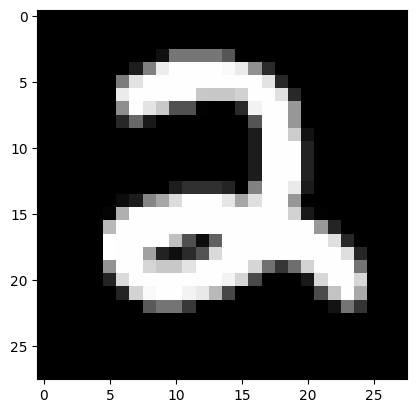

Prediction: 2, Probability: [0.99997647]


In [69]:
def test_random():
    rand_idx = np.random.choice(Y_valid.shape[0])
    x = X_valid[:, rand_idx].reshape(-1,1)
    y = Y_valid[rand_idx]
    _,_,_, a = forward_pass(x,W1,b1,W2,b2)
    prediction = a.argmax()
    probability = a[prediction]
    print("Index:", rand_idx)
    plt.gray()
    plt.imshow(x.reshape(28,28), interpolation='nearest')
    plt.show()
    print(f"Prediction: {y}, Probability: {probability}")
test_random()